# Prepare working db
- Load data
- df cleaning
- Create label for recruting status
- Export full dataset to sqlite

In [1]:
import json, os
import numpy as np
import pandas as pd
import sqlite3
import shutil
import matplotlib.pyplot as plt
# import nltk

## Load json file with parsed information

In [2]:
# paths
path_to_json_file = os.path.abspath('../data/json/')

### json file
json_file = '/all_parsed_data_json' #name json file  
# json_file = '/sample_json' #sample json file for testing  

file = '{}{}.json'.format(path_to_json_file, json_file)

In [3]:
# load json file
df = pd.read_json(file)

In [4]:
# Display full dataframe
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.width', 1000)

In [5]:
# Check data
df.shape

(321599, 24)

In [6]:
# Remove all_files folder
path_to_all_files = os.path.abspath('../data/all_trials//')

def remove_extra_folders(folder):
    try:
        shutil.rmtree(folder)
        print("\nunzip folder deleted")
    except IOError as e:
        print(e)
        pass

In [7]:
%time remove_extra_folders(path_to_all_files)

[Errno 2] No such file or directory: '/Users/cms/Sites/clinical-trials/mvp/data/all_trials'
CPU times: user 756 µs, sys: 1.38 ms, total: 2.14 ms
Wall time: 4.46 ms


## Format dataset

In [8]:
# function to change column type

def data_types(dataframe, cols = [], to_type = ''):
    for col in cols:
        dataframe[col] = df[col].astype(to_type)
        

In [53]:
columns_dates = ['study_first_submitted', 'last_update_submitted', 'verification_date']
data_types(df, columns_dates, 'datetime64')

In [54]:
# Extract year 
df['year_submitted'] = df['study_first_submitted'].dt.year
df['year_last_updated'] = df['last_update_submitted'].dt.year
df['verification_year'] = df['verification_date'].dt.year

In [55]:
# Remove unnecesary columns
# df.drop(columns_dates, axis = 1, inplace=True)

In [56]:
# columns_to_drop = ['study_first_posted', 'last_update_posted', 'verification_date']
# df.drop(columns_to_drop, axis = 1, inplace=True)

In [57]:
# Remove /n in all df
df = df.replace(r'\n',' ', regex=True)

In [58]:
# Create new column for all text
df['all_text'] = df['source'] + ' ' + df['brief_title'] + ' ' + df['condition'] + ' ' + df['condition_browse/mesh_term'] + ' '+ df['intervention_browse/mesh_term'] + ' '+ df['detailed_description/textblock'] + ' ' + df['brief_summary/textblock']

# All_text in lowercase
df['all_text'] = df['all_text'].str.lower()

# remove extra whitespace
df.all_text = df.all_text.replace('\s+', ' ', regex=True)


In [59]:
# Remove extra white space in summary
df['brief_summary/textblock'] = df['brief_summary/textblock'].replace('\s+', ' ', regex=True)
df['brief_summary/textblock'][0]

' This study was conducted to compare the activities of erlotinib to that of intravenous, platinum-based therapy in the treatment of non-small cell lung cancer (NSCLC). The goal of this trial was to demonstrate clinical equivalence of erlotinib to platinum-based frontline therapy, compared to historical controls. '

In [60]:
# # add url columns
url_string = 'https://clinicaltrials.gov/ct2/show/'
df['url'] = url_string + df['nct_id'].astype(str)

## Recruiting status
- Create criteria for filtering recruiting status
- Create new column with labels

In [61]:
''' Recruiting status 
0 - Not recruting, including all records not updated 
1 - Possibily recruiting. Define time range for category 
2 - Recruiting

'''

df.overall_status.unique()

array(['Terminated', 'Recruiting', 'Active, not recruiting', 'Completed',
       'Unknown status', 'Suspended', 'Not yet recruiting', 'Withheld',
       'Withdrawn', 'Enrolling by invitation', 'Available',
       'No longer available', 'Approved for marketing',
       'Temporarily not available'], dtype=object)

In [72]:
# Selecting open trials
# https://clinicaltrials.gov/ct2/help/glossary/recruitment-status

recruiting = df[(df['overall_status'] == "Recruiting") | \
                (df['overall_status'] == "Not yet recruiting") | \
                (df['overall_status'] == "Available for expanded access")]

# Check recruiting studies
print('Total of trials classified as recruiting: {}'.format(len(recruiting)))

print('Trials not verified in the last two years 2017-2019: {}'.\
      format(len(recruiting[recruiting['verification_year'] < 2017])))

Total of trials classified as recruiting: 66437
Trials not verified in the last two years 2017-2019: 30989


In [73]:
recruiting.overall_status.unique()

array(['Recruiting', 'Not yet recruiting'], dtype=object)

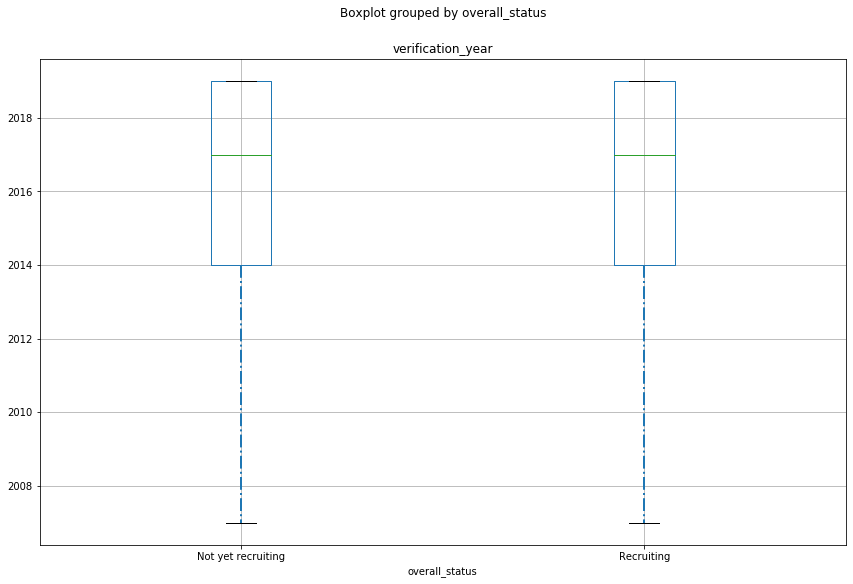

In [108]:
# Trials by verification date

'''Unknown: A study with a status of Recruiting, Not yet recruiting, 
or Active, not recruiting and whose status has not been verified within the past 2 years. 

** Studies with an Unknown recruitment status are considered open studies or closed studies, 
depending on their last known recruitment status**

'''
recruiting.boxplot(column='verification_year', by='overall_status', \
                   figsize=(14,9), showfliers=False, meanline=True,\
                   whiskerprops = dict(linestyle='-.', linewidth=2))

# recruiting.boxplot(column='year_last_updated')
# recruiting['verification_year'].plot(kind='box', figsize=(10,7))
# recruiting['year_last_updated'].plot(kind='box', figsize=(10,7))

In [32]:
# Create new column with recruiting status based on verification date


In [124]:
# Function to assign recruiting labels
options = [
    (df['verification_year'] < 2017),
    (df['verification_year'] > 2017) & (df['overall_status'] == "Recruiting") | \
                (df['overall_status'] == "Not yet recruiting") | \
                (df['overall_status'] == "Available for expanded access")]
labels = [0, 1]
df['recruiting_labels'] = np.select(options, labels, default=0)

df['recruiting_labels'].value_counts()


0    292126
1     29473
Name: recruiting_labels, dtype: int64

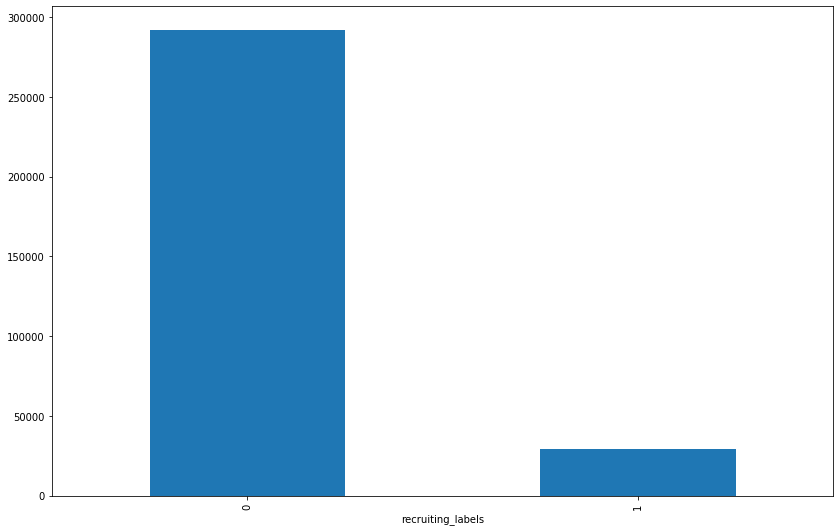

In [131]:
df.groupby('recruiting_labels').size().plot(kind='bar', figsize=(14,9))

# Create sqlite db

In [145]:
# Create folder

path_to_working_datasets = os.path.abspath('../data/working_data')

try: 
    os.mkdir(path_to_working_datasets)
except:
    pass
    print('Error')

Error


In [146]:
# Create and connect to db
conn = sqlite3.connect('../data/working_data/working-database.db')
conn


In [147]:
# upload df to database: define schema
%time df.to_sql('all_trials', con=conn)

CPU times: user 9.29 s, sys: 3.44 s, total: 12.7 s
Wall time: 15.7 s


In [149]:
# get list of indexes
pd.read_sql_query("PRAGMA index_list(all_trials);", conn)

,seq,name,unique,origin,partial
0,0,ix_all_trials_index,0,c,0


In [150]:
# test 1. Filter by condition
%time search_query = pd.read_sql_query("SELECT * from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
search_query.head()

CPU times: user 2.89 s, sys: 8.66 s, total: 11.5 s
Wall time: 34.5 s


,index,nct_id,study_first_submitted,source,brief_title,overall_status,verification_date,study_type,study_first_posted,last_update_submitted,...,sponsors/lead_sponsor/agency_class,study_design_info/allocation,study_design_info/intervention_model,study_design_info/primary_purpose,year_submitted,year_last_updated,all_text,url,verification_year,recruiting_labels
0,100007,NCT01952054,2013-09-20 00:00:00,M.D. Anderson Cancer Center,Denosumab for Breast Cancer With Bone Mets,Completed,2016-05-25 00:00:00,Interventional,"September 27, 2013",2019-03-22 00:00:00,...,Other,None,Single Group Assignment,Treatment,2013,2019,m.d. anderson cancer center denosumab for brea...,https://clinicaltrials.gov/ct2/show/NCT01952054,2016.0,0
1,100039,NCT03366428,2017-12-04 00:00:00,"Daiichi Sankyo, Inc.",Phase 1 Study to Evaluate the Effect of DS-820...,"Active, not recruiting",2013-08-01 00:00:00,Interventional,"December 8, 2017",2019-07-12 00:00:00,...,Industry,None,Single Group Assignment,Treatment,2017,2019,"daiichi sankyo, inc. phase 1 study to evaluate...",https://clinicaltrials.gov/ct2/show/NCT03366428,2013.0,0
2,100054,NCT02358837,2015-01-12 00:00:00,"University Hospital, Basel, Switzerland",Improving Breast Cancer Diagnostic by Novel so...,Completed,2015-11-01 00:00:00,Observational [Patient Registry],"February 9, 2015",2018-05-15 00:00:00,...,Other,None,None,None,2015,2018,"university hospital, basel, switzerland improv...",https://clinicaltrials.gov/ct2/show/NCT02358837,2015.0,0
3,100055,NCT03012477,2016-12-19 00:00:00,Dana-Farber Cancer Institute,CISPLATIN + AZD-1775 In Breast Cancer,"Active, not recruiting",2015-05-01 00:00:00,Interventional,"January 6, 2017",2019-05-15 00:00:00,...,Other,None,Single Group Assignment,Treatment,2016,2019,dana-farber cancer institute cisplatin + azd-1...,https://clinicaltrials.gov/ct2/show/NCT03012477,2015.0,0
4,100106,NCT02908178,2016-08-30 00:00:00,Yale University,Comparative Effectiveness of Sentinel Lymph No...,Completed,2017-07-01 00:00:00,Observational,"September 20, 2016",2019-05-01 00:00:00,...,Other,None,None,None,2016,2019,yale university comparative effectiveness of s...,https://clinicaltrials.gov/ct2/show/NCT02908178,2017.0,0


In [152]:
# test 2. Filter by recruiting status = 1
%time search_query = pd.read_sql_query("SELECT * from all_trials WHERE recruiting_labels == 1;", conn)
len(search_query)

CPU times: user 1.87 s, sys: 3.56 s, total: 5.43 s
Wall time: 14.1 s


29473

In [153]:
# Create index on all_text column
c = conn.cursor()
%time c.execute("CREATE INDEX idx1 ON all_trials(all_text)")
conn.commit()

CPU times: user 3.27 s, sys: 15.3 s, total: 18.5 s
Wall time: 52.2 s


In [154]:
# get list of indexes
pd.read_sql_query("PRAGMA index_list(all_trials);", conn)

,seq,name,unique,origin,partial
0,0,idx1,0,c,0
1,1,ix_all_trials_index,0,c,0


In [156]:
# test new query
%time search_query = pd.read_sql_query("SELECT * from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
search_query.head()

CPU times: user 3.03 s, sys: 7.31 s, total: 10.3 s
Wall time: 31.5 s


,index,nct_id,study_first_submitted,source,brief_title,overall_status,verification_date,study_type,study_first_posted,last_update_submitted,...,sponsors/lead_sponsor/agency_class,study_design_info/allocation,study_design_info/intervention_model,study_design_info/primary_purpose,year_submitted,year_last_updated,all_text,url,verification_year,recruiting_labels
0,100007,NCT01952054,2013-09-20 00:00:00,M.D. Anderson Cancer Center,Denosumab for Breast Cancer With Bone Mets,Completed,2016-05-25 00:00:00,Interventional,"September 27, 2013",2019-03-22 00:00:00,...,Other,None,Single Group Assignment,Treatment,2013,2019,m.d. anderson cancer center denosumab for brea...,https://clinicaltrials.gov/ct2/show/NCT01952054,2016.0,0
1,100039,NCT03366428,2017-12-04 00:00:00,"Daiichi Sankyo, Inc.",Phase 1 Study to Evaluate the Effect of DS-820...,"Active, not recruiting",2013-08-01 00:00:00,Interventional,"December 8, 2017",2019-07-12 00:00:00,...,Industry,None,Single Group Assignment,Treatment,2017,2019,"daiichi sankyo, inc. phase 1 study to evaluate...",https://clinicaltrials.gov/ct2/show/NCT03366428,2013.0,0
2,100054,NCT02358837,2015-01-12 00:00:00,"University Hospital, Basel, Switzerland",Improving Breast Cancer Diagnostic by Novel so...,Completed,2015-11-01 00:00:00,Observational [Patient Registry],"February 9, 2015",2018-05-15 00:00:00,...,Other,None,None,None,2015,2018,"university hospital, basel, switzerland improv...",https://clinicaltrials.gov/ct2/show/NCT02358837,2015.0,0
3,100055,NCT03012477,2016-12-19 00:00:00,Dana-Farber Cancer Institute,CISPLATIN + AZD-1775 In Breast Cancer,"Active, not recruiting",2015-05-01 00:00:00,Interventional,"January 6, 2017",2019-05-15 00:00:00,...,Other,None,Single Group Assignment,Treatment,2016,2019,dana-farber cancer institute cisplatin + azd-1...,https://clinicaltrials.gov/ct2/show/NCT03012477,2015.0,0
4,100106,NCT02908178,2016-08-30 00:00:00,Yale University,Comparative Effectiveness of Sentinel Lymph No...,Completed,2017-07-01 00:00:00,Observational,"September 20, 2016",2019-05-01 00:00:00,...,Other,None,None,None,2016,2019,yale university comparative effectiveness of s...,https://clinicaltrials.gov/ct2/show/NCT02908178,2017.0,0


In [158]:
%time new_query = pd.read_sql_query("SELECT nct_id from all_trials WHERE all_text LIKE '%breast cancer%';", conn).head()
new_query.head()

CPU times: user 2.15 s, sys: 5.17 s, total: 7.31 s
Wall time: 24.7 s


,nct_id
0,NCT01952054
1,NCT03366428
2,NCT02358837
3,NCT03012477
4,NCT02908178


In [157]:
'''
Optimize performance
https://medium.com/@JasonWyatt/squeezing-performance-from-sqlite-indexes-indexes-c4e175f3c346
'''

'\nOptimize performance\nhttps://medium.com/@JasonWyatt/squeezing-performance-from-sqlite-indexes-indexes-c4e175f3c346\n'

_____

## Test queries speed

In [ ]:
# Check data types
# pd.read_sql_query("PRAGMA table_info(all_trials);", conn)

In [ ]:
# Time query with WHERE condition
%time search_query = pd.read_sql_query("SELECT * from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
search_query.head()

In [ ]:
# Time query with WHERE condition, return nct_id
%time filtered_query = pd.read_sql_query("SELECT nct_id from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
filtered_query.head()

In [ ]:
# drop original index
%time c.execute("DROP INDEX ix_all_trials_index")
conn.commit()


## Test queries after creating index

In [ ]:
# Time query with WHERE condition after creating index
%time optimized_query = pd.read_sql_query("SELECT * from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
optimized_query.head()

In [ ]:
# Return only nct_id
%time new_query = pd.read_sql_query("SELECT nct_id from all_trials WHERE all_text LIKE '%breast cancer%';", conn).head()
new_query.head()


## Pending: Test search pattern to optimize queries, return results

## Preprocess dataset
- Tokenize, Lemmatize / Stem
- Remove stopwords

In [ ]:
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

# porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

In [ ]:
# Stemming
# def stem_sentences(text):
#     tokens = text.split()
#     stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
#     return ' '.join(stemmed_tokens)

# df['stems'] = df['all_text'].apply(stem_sentences)

In [ ]:
# Lemmatizing
def lemm_sentences(text):
    tokens = text.split()
    lemm_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemm_tokens)

df['lemmas'] = df['all_text'].apply(lemm_sentences)

In [ ]:
# Remove stop words [not needed with countvectorizer]
# stop_words = stopwords.words('english')
# df['tokens'] = df['lemmas'].apply(lambda x: [item for item in x.split() if item not in stop_words])

In [ ]:
df.lemmas[0:5]

## Bags of words

In [ ]:
# Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re

In [ ]:
pat_numbers = lambda x: re.sub(r'(\d)+', '', x.lower())

cv = CountVectorizer(stop_words='english',
                     preprocessor = pat_numbers,
                     max_features = 1800,
                     lowercase = True,
                     max_df = 0.8,
                     ngram_range = (1, 3))

In [ ]:
docs = list(df['lemmas'])

X = cv.fit_transform(docs)

In [ ]:
len(cv.vocabulary_)

In [ ]:
word_counts = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

In [ ]:
# add nct_id to word_counts df
nct_id = df['nct_id']

df_word_counts = pd.merge(nct_id, word_counts, left_index=True, right_index=True)

In [ ]:
df_word_counts.head()

_______

In [ ]:
# Check all dataframes in space
%who DataFrame

In [ ]:
# upload count_vectorizer to database
# sqlite limit = 2000
df_word_counts.to_sql('word_counts', con=conn)

In [ ]:
df_counts = pd.read_sql_query("SELECT * from word_counts;", conn)
df_counts.head()

In [ ]:
# List databases
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

In [ ]:
conn.close()

--------

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
transformer = TfidfTransformer()
tweights = transformer.fit_transform(X)
tweights

In [ ]:
# turn weights data into a dataframe
tf = pd.DataFrame(tweights.toarray(), columns=cv.get_feature_names())

In [ ]:
# Top terms by average tf-idf weight
weights = np.asarray(tweights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cv.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

In [ ]:
# Create new dataframe with nct-id and merge wth tf by index
pd.set_option('display.max_columns', None) 

df_tf = df['nct_id']
df_tf.head()

In [ ]:
df_tf = pd.merge(df_tf, tf, left_index=True, right_index=True)

In [ ]:
df_tf.head()

## Test merged dataframes with tf-idf results

In [ ]:
# import random

# def compare_results():
#     row = random.randint(0,3000)
#     df_tf.drop('nct_id', axis = 1)
#     print('Random row: {}'.format(row))
#     return df_tf.loc[row], tf.loc[row]

In [ ]:
# compare_results()

## Calculate correlation between docs

In [ ]:
# calculate similary
similarity = tweights * tweights.T

In [ ]:
# Save all data in a dataframe
df_docs_similarity = pd.DataFrame(similarity.toarray())

<b>To-do: Give a NTC-ID record, find similar documents
& return dataframe with results</b>

In [ ]:
# Find more similar documents of a given record

def find_similar_docs(record, rate):
    trials_id = []
    treshold = rate
    similar_index = df_docs_similarity.iloc[record][df_docs_similarity.iloc[record] > treshold].index
    
    for i in similar_index.values:
        trials_id.append(i)
        
    print('{} similar trials with treshold {}'.format(len(trials_id), treshold))
    return df.iloc[trials_id]


In [ ]:
find_similar_docs(0, 0.50)